In [1]:
import os
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
from scipy.integrate import trapz, quad
import time
from scipy.special import erf

In [2]:
stellarCatalog = "../stellarCatalogs/dr25_stellar_supp_gaia_clean_notimeout_GKM.txt"
pcCatalog = "koiCatalogs/dr25_GKM_PCs_notimeout.csv"

period_rng = (1, 500)
n_period = 101
rp_rng = (2.5, 5)
n_rp = 101

# for quick tests
nWalkers = 25
nBurnin = 500
nMcmc = 1000

whichRadii = "corrected"
def getRadii(catalog):
    if whichRadii == "corrected":
        return catalog.corrected_prad
    elif whichRadii == "kic":
        return catalog.koi_prad
    else:
        raise ValueError('Bad whichRadii string')

In [3]:
stellarTargets = pd.read_csv(stellarCatalog)
base_kois = pd.read_csv(pcCatalog)
m = (period_rng[0] <= base_kois.koi_period) & (base_kois.koi_period <= period_rng[1])
thisRadii = getRadii(base_kois)
m &= np.isfinite(thisRadii) & (rp_rng[0] <= thisRadii) & (thisRadii <= rp_rng[1])
    
kois = pd.DataFrame(base_kois[m])
allKois = kois

In [4]:
period = np.logspace(np.log10(1), np.log10(500), num=7)
rp = np.logspace(np.log10(2.5), np.log10(5), num=5)
period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
periodShape = period_grid.shape

In [5]:
period, rp

(array([  1.        ,   2.81726911,   7.93700526,  22.36067977,
         62.99605249, 177.47683299, 500.        ]),
 array([2.5       , 2.97301779, 3.53553391, 4.20448208, 5.        ]))

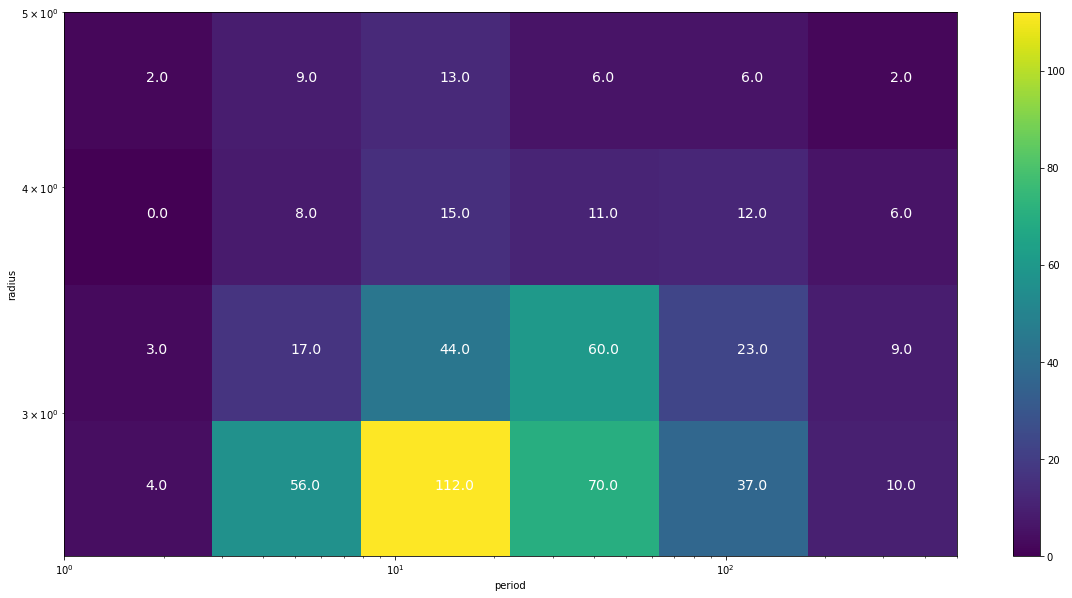

In [6]:
H, xedges, yedges = np.histogram2d(kois.koi_period, getRadii(kois), bins=(period, rp))
xcent = 0.5 * (xedges[1:] + xedges[:-1])
ycent = 0.5 * (yedges[1:] + yedges[:-1])

fig, ax = plt.subplots(figsize=(20, 10))
im = ax.pcolormesh(period_grid, rp_grid, H)

for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        ax.text(xcent[j],ycent[i], H.T[i,j], 
                color="white", ha="center", va="center", fontsize=14)

plt.xlabel('period')
plt.ylabel('radius')
plt.xscale('log')
plt.yscale('log')
fig.colorbar(im)
plt.show()

In [7]:
a = np.linspace(np.log10(period_rng[0]), np.log10(period_rng[1]), num=7)
b = np.diff(np.linspace(np.log10(period_rng[0]), np.log10(period_rng[1]), num=7))
c = 10**np.append(a, a[-1]+b[0])
d = np.diff(c)
period_q = d[-1]

a = np.linspace(np.log10(rp_rng[0]), np.log10(rp_rng[1]), num=5)
b = np.diff(np.linspace(np.log10(rp_rng[0]), np.log10(rp_rng[1]), num=5))
c = 10**np.append(a, a[-1]+b[0])
d = np.diff(c)
rp_q = d[-1]

print(period_q, rp_q)

908.6345569239197 0.9460355750136058


In [8]:
inputgrid = "../completenessContours/out0702_sc0_GKM_baseline.fits.gz"

hdulist = fits.open(inputgrid)
cumulative_array = hdulist[0].data
kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
probdet = np.transpose(cumulative_array[0])
probtot = np.transpose(cumulative_array[1])
prihdr = hdulist[0].header
min_comp_period = prihdr["MINPER"]
max_comp_period = prihdr["MAXPER"]
n_comp_period = prihdr["NPER"]
min_comp_rp = prihdr["MINRP"]
max_comp_rp = prihdr["MAXRP"]
n_comp_rp = prihdr["NRP"]
print(hdulist[0].header,)

period_want = np.linspace(min_comp_period, max_comp_period, n_comp_period)
rp_want = np.linspace(min_comp_rp, max_comp_rp, n_comp_rp)
period_want2d, rp_want2d = np.meshgrid(period_want, rp_want)

numCompVeInterp = RectBivariateSpline(period_want, rp_want, probtot)
numProbDetInterp = RectBivariateSpline(period_want, rp_want, probdet)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                 1000                                                  NAXIS2  =                 1000                                                  NAXIS3  =                    2                                                  EXTEND  =                    T                                                  MINPER  =                  1.0                                                  MAXPER  =                500.0                                                  NPER    =                 1000                                                  MINRP   =                  1.7                                                  MAXRP   =                  6.0                                                  NRP     =                 1000          

In [9]:
summedCompleteness = numCompVeInterp(period, rp)
summedProbDet = numProbDetInterp(period, rp)

In [10]:
koi_periods = np.array(kois.koi_period)
koi_rps = np.array(getRadii(kois))

vol = np.diff(period_grid, axis=0)[:, :-1] * np.diff(rp_grid, axis=1)[:-1, :]

In [11]:
def set_bounds(model):
    if model == "dualPowerLaw":
        bounds = [(0, 5), (-5, 5), (-6, 5)]
    elif model == "brokenPowerLawY":
        bounds = [(0, 5), (-6, 5), (-5, 10), (-5, 5), (0, 100)]
    elif model == "kneeXpowerY":
        bounds = [(0, 5), (-6, 5), (-5, 10), (-5, 5), (0, 100)]
    elif model == "kneeXgenLogisticY":
        bounds = [(0, 5), (-6, 5), (-5, 10), (-5, 5), (0, 100), (-5, 5), (-5, 5)]
    elif model == "kneeXLogisticY2":
        bounds = [(0, 5), (-6, 5), (-5, 10), (-5, 5), (0, 100), (-5, 5)]
    elif model == "kneeXLogisticY3":
        bounds = [(0, 5), (-6, 5), (-5, 10), (-5, 5), (0, 100)]
    elif model == "kneeXLogisticY4":
        bounds = [(0, 5), (-6, 5), (-5, 10), (-5, 5), (0, 100), (-5, 5)]
    elif model == "kneeXLogisticY5":
        bounds = [(0, 5), (-6, 5), (-5, 10), (-5, 5), (0, 100), (-5, 5), (-10, 5)]
    elif model == "kneeXgaussY":
        bounds = [(0, 5), (-6, 5), (-5, 10), (-5, 5), (0, 100)]
    else:
        bounds = None
        raise ValueError('Bad model name')
    
    return(bounds)

In [12]:
# population analysis functions modified from Daniel Foreman Mackey's https://dfm.io/posts/exopop/

# We'll reuse these functions to plot all of our results.
def make_plot(pop_comp, x0, x, y, ax, q):
    
    pop = 0.5*(pop_comp[:, 1:] + pop_comp[:, :-1])
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    
    x = np.append(np.diff(x), q)
    a, b, c, d, e = np.percentile(pop * x, [2.5, 16, 50, 84, 97.5], axis=0)
    
    ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    ax.plot(x0, c, "k", lw=1)

def plot_results(samples):
    #  Loop through the samples and compute the list of population models.
    samples = np.atleast_2d(samples)
    pop = np.empty((len(samples), period_grid.shape[0], period_grid.shape[1]))
    gamma_earth = np.empty((len(samples)))

    for i, p in enumerate(samples):
        pop[i] = rateModel(period_grid, rp_grid, period_rng, rp_rng, p, model)
        gamma_earth[i] = rateModel(365.25, 1.0, period_rng, rp_rng, p, model) * 365.
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Integrate over period.
    dx = 0.25
    x = rp.copy()
    n, _ = np.histogram(koi_rps, x)
    
    fsize = 18
    # Plot the observed radius distribution.
    ax = axes[0, 0]
    make_plot(pop * summedCompleteness[None, :, :], rp, x, period, ax, q=rp_q)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    #ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_xlabel("$R_p\,[R_\oplus]$", fontsize = fsize)
    ax.set_ylabel("# of detected planets", fontsize = fsize)
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    
    # Plot the true radius distribution.
    ax = axes[0, 1]
    make_plot(pop, rp, x, period, ax, q=rp_q)
    #ax.set_xlim(rp_rng[0], rp_rng[1])
    #ax.set_ylim(0, 0.37)
    ax.set_xlabel("$R_p\,[R_\oplus]$", fontsize = fsize)
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}R$", fontsize = fsize)
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    
    # Integrate over period.
    dx = 31.25
    x = period.copy()
    n, _ = np.histogram(koi_periods, x)
    
    # Plot the observed period distribution.
    ax = axes[1, 0]
    make_plot(np.swapaxes(pop * summedCompleteness[None, :, :], 1, 2), period, x, rp, ax, q=period_q)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    #ax.set_xlim(period_rng[0], period_rng[1])
    #ax.set_ylim(0, 79)
    ax.set_xlabel("$P\,[\mathrm{days}]$", fontsize = fsize)
    ax.set_ylabel("# of detected planets", fontsize = fsize)
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    
    # Plot the true period distribution.
    ax = axes[1, 1]
    make_plot(np.swapaxes(pop, 1, 2), period, x, rp, ax, q=period_q)
    #ax.set_xlim(period_rng[0], period_rng[1])
    #ax.set_ylim(0, 0.27)
    ax.set_xlabel("$P\,[\mathrm{days}]$", fontsize = fsize)
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}P$", fontsize = fsize)
    #ax.set_xscale('log')
    #ax.set_yscale('log')

    return gamma_earth, fig

In [13]:
import numpy as np
from scipy.integrate import trapz

def knee(x, beta, gamma, xb):
    f = x**beta * (1-np.exp(-(x/xb)**gamma))
    return(f)

def gen_logistic(y, alpha, Q, nu):
    f = (1 + Q*np.exp(alpha*y))**(-1/nu)
    return(f)

def ano_logistic(y, alpha, Q, M):
    f = 1/(1 + Q*np.exp(alpha*y - M))
    return(f)

def rateModel(x, y, xRange, yRange, theta, model):
    if model == "dualPowerLaw":
        f0, alpha, beta = theta
        ap1 = alpha+1
        bp1 = beta+1
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)) 

    elif model == "brokenPowerLawY":
        f0, alpha, beta, delta, xb = theta
        ap1 = alpha+1
        bp1 = beta+1
        dt1 = delta+1
        if np.isscalar(x) == True:
            xArray = np.asarray([x])
            yArray = np.asarray([y])
        else:
            xArray = x
            yArray = y
        
        rx = np.zeros(np.shape(xArray))
        x1 = np.where(xArray < xb)
        x2 = np.where(xArray >= xb)
        rx[x1] = bp1*(xArray[x1]**beta) / (xb**bp1 - xRange[0]**bp1)
        rx[x2] = dt1*(xArray[x2]**delta) / (xRange[1]**dt1 - xb**dt1)
        
        ry = (ap1*(yArray**alpha)/(yRange[1]**ap1-yRange[0]**ap1))
        r = f0*rx*ry

    elif model == "kneeXpowerY":
        f0, alpha, beta, gamma, xb = theta
        ap1 = alpha+1
        
        Cinv = quad(knee, xRange[0], xRange[1], args=(beta, gamma, xb))
        rx = (x**beta * (1-np.exp(-(x/xb)**gamma)))/Cinv[0]
        ry = (ap1*(y**alpha)/(yRange[1]**ap1-yRange[0]**ap1)) 
        r = f0*rx*ry

    elif model=="kneeXgenLogisticY":
        f0, alpha, beta, gamma, xb, Q, nu = theta
        nui = 1/nu 
        
        Cxinv = quad(knee, xRange[0], xRange[1], args=(beta, gamma, xb))
        rx = (x**beta * (1-np.exp(-(x/xb)**gamma)))/Cxinv[0]

        Cyinv = quad(gen_logistic, yRange[0], yRange[1], args=(alpha, Q, nu))
        ry = ((1 + Q*np.exp(alpha*y))**-nui)/Cyinv[0]
        r = f0*rx*ry

    elif model=="kneeXLogisticY2":
        f0, alpha, beta, gamma, xb, Q = theta
        nui = 1 
        
        Cxinv = quad(knee, xRange[0], xRange[1], args=(beta, gamma, xb))
        rx = (x**beta * (1-np.exp(-(x/xb)**gamma)))/Cxinv[0]

        Cyinv = quad(gen_logistic, yRange[0], yRange[1], args=(alpha, Q, 1))
        ry = ((1 + Q*np.exp(alpha*y))**-nui)/Cyinv[0]
        r = f0*rx*ry

    elif model=="kneeXLogisticY3":
        f0, alpha, beta, gamma, xb = theta
        nui = 1 
        
        Cxinv = quad(knee, xRange[0], xRange[1], args=(beta, gamma, xb))
        rx = (x**beta * (1-np.exp(-(x/xb)**gamma)))/Cxinv[0]

        Cyinv = quad(gen_logistic, yRange[0], yRange[1], args=(alpha, 1, 1))
        ry = ((1 + np.exp(alpha*y))**-nui)/Cyinv[0]
        r = f0*rx*ry
        

    elif model=="kneeXLogisticY4":
        f0, alpha, beta, gamma, xb, nu = theta
        nui = 1 
        
        Cxinv = quad(knee, xRange[0], xRange[1], args=(beta, gamma, xb))
        rx = (x**beta * (1-np.exp(-(x/xb)**gamma)))/Cxinv[0]

        Cyinv = quad(gen_logistic, yRange[0], yRange[1], args=(alpha, 1, nu))
        ry = ((1 + np.exp(alpha*y))**-nui)/Cyinv[0]
        r = f0*rx*ry
        
    elif model=="kneeXLogisticY5":
        f0, alpha, beta, gamma, xb, Q, M = theta
        nui = 1 
        
        Cxinv = quad(knee, xRange[0], xRange[1], args=(beta, gamma, xb))
        rx = (x**beta * (1-np.exp(-(x/xb)**gamma)))/Cxinv[0]

        Cyinv = quad(ano_logistic, yRange[0], yRange[1], args=(alpha, Q, M))
        ry = ((1 + np.exp(alpha*y - M))**-1)/Cyinv[0]
        r = f0*rx*ry

    elif model=="kneeXgaussY":
        f0, sigma, beta, gamma, xb = theta
        sig = np.sqrt(2)*sigma
        
        Cxinv = quad(knee, xRange[0], xRange[1], args=(beta, gamma, xb))
        rx = (x**beta * (1-np.exp(-(x/xb)**gamma)))/Cxinv[0]
        
        Cyinv = -erf(yRange[0]/sig) + erf(yRange[1]/sig)
        ry = (np.sqrt(2)/(np.sqrt(np.pi)*sigma)) * np.exp(-(y/sig)**2) / Cyinv
        r = f0*rx*ry
    else:
        raise ValueError('Bad model name');      
    return r

def getModelLabels(model):
    if model == "dualPowerLaw":
        return ["f0", r"$\alpha$", r"$\beta$"]
    elif model == "brokenPowerLawY":
        return ["f0", r"$\alpha$", r"$\beta$", r"$\delta$", "Xb"]
    elif model == "kneeXpowerY":
        return ["f0", r"$\alpha$", r"$\beta$", r"$\gamma$", "Xb"]
    elif model == "kneeXgenLogisticY":
        return ["f0", r"$\alpha$", r"$\beta$", r"$\gamma$", "Xb", "Q", r"$\nu$"]
    elif model == "kneeXLogisticY2":
        return ["f0", r"$\alpha$", r"$\beta$", r"$\gamma$", "Xb", "Q"]
    elif model == "kneeXLogisticY3":
        return ["f0", r"$\alpha$", r"$\beta$", r"$\gamma$", "Xb"]
    elif model == "kneeXLogisticY4":
        return ["f0", r"$\alpha$", r"$\beta$", r"$\gamma$", "Xb", r"$\nu$"]
    elif model == "kneeXLogisticY5":
        return ["f0", r"$\alpha$", r"$\beta$", r"$\gamma$", "Xb", "Q", "M"]
    elif model=="kneeXgaussY":
        return ["f0", r"$\sigma$", r"$\beta$", r"$\gamma$", "Xb"]
    else:
        raise ValueError('Bad model name');

def initRateModel(model):
    if model == "dualPowerLaw":
        f0 = 1
        alpha = 1
        beta = 1
        theta = [f0, alpha, beta]
    elif model == "brokenPowerLawY":
        f0 = 0.75
        alpha = -2.0
        beta = 0.5
        delta = -1
        xb = 10
        theta = [f0, alpha, beta, delta, xb];
    elif model == "kneeXpowerY":
        f0 = 0.75
        alpha = -2.0
        beta = 0.5
        gamma = -1
        xb = 10
        theta = [f0, alpha, beta, gamma, xb]
    elif model == "kneeXgenLogisticY":
        f0 = 0.75
        alpha = 0.5
        beta = 0.5
        gamma = -1
        xb = 10
        Q = 1
        nu = 1
        theta = [f0, alpha, beta, gamma, xb, Q, nu]
    elif model == "kneeXLogisticY2":
        f0 = 0.75
        alpha = 0.5
        beta = 0.5
        gamma = -1
        xb = 10
        Q = 1
        theta = [f0, alpha, beta, gamma, xb, Q]
    elif model == "kneeXLogisticY3":
        f0 = 0.75
        alpha = 0.5
        beta = -1
        gamma = 0
        xb = 10
        theta = [f0, alpha, beta, gamma, xb]
    elif model == "kneeXLogisticY4":
        f0 = 0.75
        alpha = 0.5
        beta = -1
        gamma = 0
        xb = 20
        nu = 1
        theta = [f0, alpha, beta, gamma, xb, nu]
    elif model == "kneeXLogisticY5":
        f0 = 0.75
        alpha = 0.5
        beta = -1
        gamma = 0
        xb = 20
        Q = 1
        M = 1
        theta = [f0, alpha, beta, gamma, xb, Q, M]
    elif model == "kneeXgaussY":
        f0 = 0.75
        sigma = 1
        beta = -2
        gamma = 0
        xb = 20
        theta = [f0, sigma, beta, gamma, xb]
    else:
        raise ValueError('Bad model name');
  
    return theta

def lnPoisprior(theta, model):
    if model == "dualPowerLaw":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -10.0 <= theta[2] <= 10.0:
            return 1.0
    elif model == "brokenPowerLawY":
        if 0.0 <= theta[0] <= 5.0 \
        and -6.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 10.0 \
        and -5.0 <= theta[3] <= 5.0 \
        and 0.0 <= theta[4] <= 100.0:
            return 1.0
    elif model == "kneeXpowerY":
        if 0.0 <= theta[0] <= 5.0 \
        and -6.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 10.0 \
        and -5.0 <= theta[3] <= 5.0 \
        and 0.0 <= theta[4] <= 100.0:
            return 1.0
    elif model == "kneeXgenLogisticY":
        if 0.0 <= theta[0] <= 5.0 \
        and -6.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 10.0 \
        and -5.0 <= theta[3] <= 5.0 \
        and 0.0 <= theta[4] <= 100.0 \
        and -5.0 <= theta[5] <= 5.0 \
        and -5.0 <= theta[6] <= 5.0:
            return 1.0
    elif model == "kneeXLogisticY2":
        if 0.0 <= theta[0] <= 5.0 \
        and -6.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 10.0 \
        and -5.0 <= theta[3] <= 5.0 \
        and 0.0 <= theta[4] <= 100.0 \
        and -5.0 <= theta[5] <= 5.0:
            return 1.0
    elif model == "kneeXLogisticY3":
        if 0.0 <= theta[0] <= 5.0 \
        and -6.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 10.0 \
        and -5.0 <= theta[3] <= 5.0 \
        and 0.0 <= theta[4] <= 100.0:
            return 1.0
    elif model == "kneeXLogisticY4":
        if 0.0 <= theta[0] <= 5.0 \
        and -6.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 10.0 \
        and -5.0 <= theta[3] <= 5.0 \
        and 0.0 <= theta[4] <= 100.0 \
        and -5.0 <= theta[5] <= 5.0:
            return 1.0
    elif model == "kneeXLogisticY5":
        if 0.0 <= theta[0] <= 5.0 \
        and -6.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 10.0 \
        and -5.0 <= theta[3] <= 5.0 \
        and 0.0 <= theta[4] <= 100.0 \
        and -5.0 <= theta[5] <= 5.0 \
        and -10.0 <= theta[6] <= 5.0:
            return 1.0
    elif model == "kneeXgaussY":
        if 0.0 <= theta[0] <= 5.0 \
        and -6.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 10.0 \
        and -5.0 <= theta[3] <= 5.0 \
        and 0.0 <= theta[4] <= 100.0:
            return 1.0
    else:
        raise ValueError('Bad model name');
        
    return -np.inf

def medianAndErrorbars(data):
    if data.ndim > 1:
        dataResult = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(data, [16, 50, 84],
                                                axis=0)))
        dataResult = list(dataResult)
        return dataResult
    else:
        v = np.percentile(data, [16, 50, 84])
        return [v[1], v[2]-v[1], v[1]-v[0]]

def printMedianAndErrorbars(data):
    e = medianAndErrorbars(data)
    if data.ndim > 1:
        print("printMedianAndErrorbars only works for 1D arrays")
    else:
        return "{:.3f}".format(e[0]) +"^{+" + "{:.3f}".format(e[1]) + "}_{-" + "{:.3f}".format(e[2]) + "}"

def integrate2DGrid(g, dx, dy):
    #if g.shape[0]%2 == 0 or g.shape[1]%2 == 0:
    #    raise ValueError('integrate2DGrid requires a grid with odd number of points on a side');
    return trapz(trapz(g, dx=dx), dx=dy)

def integrateRateModel(periodRange, rpRange, theta, model):
    nPts = 5
    pGrid, rGrid = np.meshgrid(np.linspace(start=periodRange[0], stop=periodRange[1], num=nPts), 
                                np.linspace(start=rpRange[0], stop=rpRange[1], num=nPts), indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    
    if theta.ndim == 1:
        y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)
        return integrate2DGrid(y, dp, dr)
    else: # assume first dimension is array of thetas
        ret = np.zeros(theta.shape[0])
        if len(ret) > 100:
            f = FloatProgress(min=0, max=len(ret))
            display(f)

        for i in range(len(ret)):
            y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta[i,:], model)
            ret[i] = integrate2DGrid(y, dp, dr)
            if len(ret) > 100:
                f.value += 1
        return ret

def integratePopTimesComp(periodRange, rpRange, theta, model, compGrid):
    nP = compGrid.shape[0]
    nR = compGrid.shape[1]

    pGrid, rGrid = np.meshgrid(np.linspace(periodRange[0], periodRange[1], nP), 
                                       np.linspace(rpRange[0], rpRange[1], nR), 
                                       indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)*compGrid
    return integrate2DGrid(y, dp, dr)

# population inference functions
def lnlike(theta):
    pop = rateModel(period_grid, rp_grid, period_rng, rp_rng, theta, model) * summedCompleteness
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    ll = np.sum(np.log(rateModel(koi_periods, koi_rps, period_rng, rp_rng, theta, model))) - norm
    return ll if np.isfinite(ll) else -np.inf

# The ln-probability function is just propotional to the ln-likelihood
# since we're assuming uniform priors.
def lnprob(theta):
    lp = lnPoisprior(theta, model)
    if not np.isfinite(lp):
        return -np.inf

    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15

In [14]:
def firstCheck(model):
    print(model)
    bounds = set_bounds(model)
    theta_0 = initRateModel(model)
    print(theta_0)
    print(nll(theta_0))
    
    r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
    print(r.x)
    ge, fig = plot_results(r.x)
    return(r)

def noReliability(model, r):
    print(model)
    ndim, nwalkers = len(r.x), nWalkers
    pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8)

    # Burn in.
    pos, _, _ = sampler.run_mcmc(pos, nBurnin)
    sampler.reset()

    # Production.
    start_time = time.time()
    pos, _, _ = sampler.run_mcmc(pos, nMcmc)
    print("--- %s seconds ---" % (time.time() - start_time))

    samples_noreliability = sampler.flatchain

    corner.corner(samples_noreliability, labels=getModelLabels(model), label_kwargs = {"fontsize": 32})
    gamma_earth_no_reliability, fig = plot_results(samples_noreliability)

    return(samples_noreliability)
    
def wReliability(model, kois):
    nTrials = 50
    print(model)
    
    f = FloatProgress(min=0, max=nTrials)
    display(f)
    
    bounds = set_bounds(model)
    allKois = kois
    for mCount in range(nTrials):
        # randomly select kois
    
        koiSelect = (np.random.rand(len(allKois)) < allKois.totalReliability)
        kois = allKois[koiSelect]
    
        koi_periods = np.array(kois.koi_period)
        koi_rps = np.array(getRadii(kois))

        theta_0 = initRateModel(model)
        r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)

        ##################################################################

        ndim, nwalkers = len(r.x), 2*len(r.x)
        pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

        # Burn in.
        pos, _, _ = sampler.run_mcmc(pos, 200)
        sampler.reset()

        # Production.
        pos, _, _ = sampler.run_mcmc(pos, 1000)

        samples = sampler.flatchain   
        if mCount == 0:
            allSamples = samples[0:-1:10,:]
        else:
            allSamples = np.concatenate((allSamples, samples[0:-1:10,:]))
    
        f.value += 1
    
    corner.corner(allSamples, labels=getModelLabels(model), label_kwargs = {"fontsize": 32});
    gamma_earth, fig = plot_results(allSamples)
    os.system("print('\a')")
    return(allSamples)

dualPowerLaw
[1, 1, 1]
5397.073444966146
[ 0.67262392 -0.1566063  -3.69492741]
dualPowerLaw
--- 2.7307260036468506 seconds ---


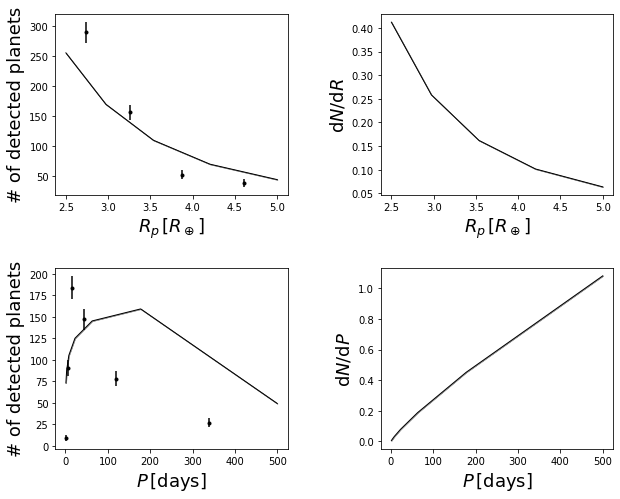

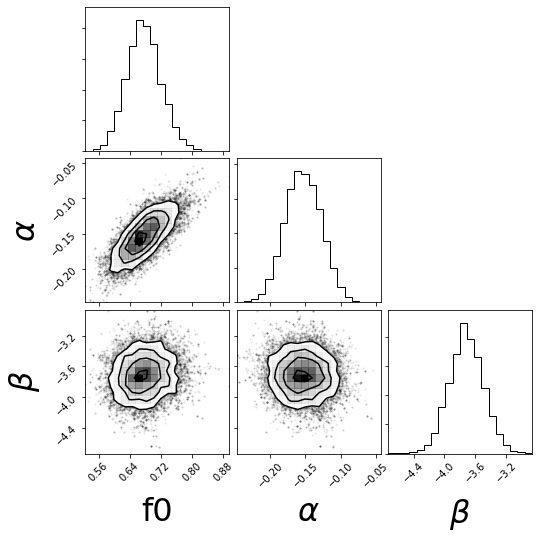

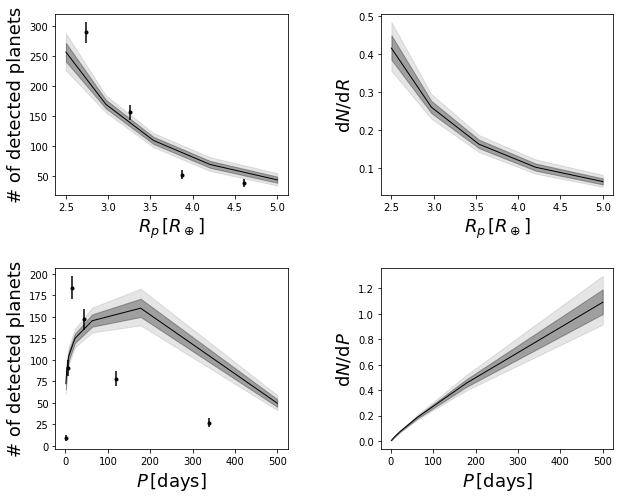

In [15]:
model = "dualPowerLaw"
r = firstCheck(model)
dualPower_noRel = noReliability(model, r)

dualPowerLaw


FloatProgress(value=0.0, max=50.0)

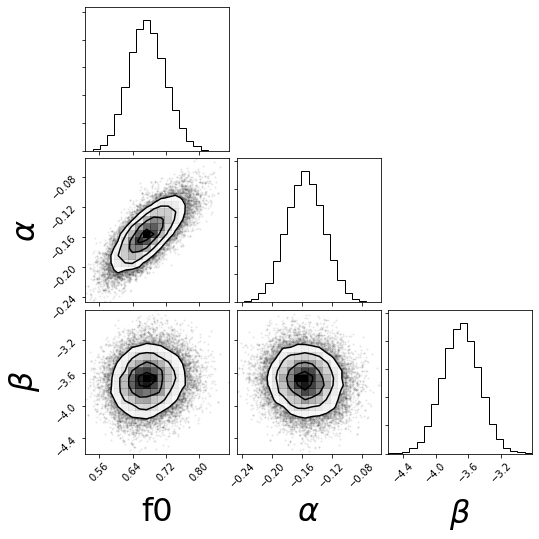

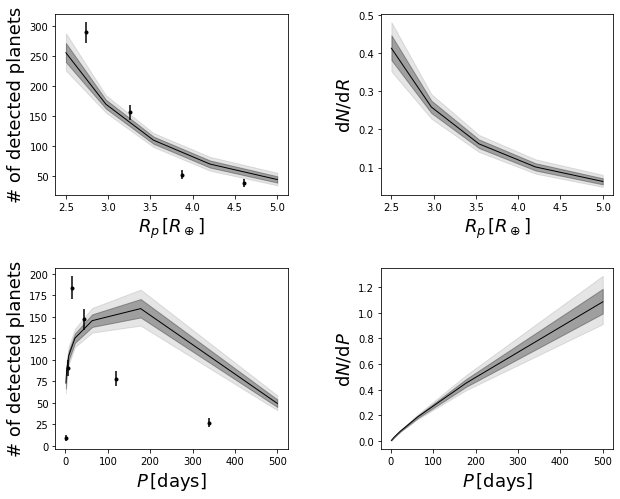

In [16]:
dualPower_wRel = wReliability(model, kois)

brokenPowerLawY
[0.75, -2.0, 0.5, -1, 10]
1000000000000000.0
[ 0.11441599 -1.94103812  0.35079352 -1.32561824 22.36066225]
brokenPowerLawY


/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: divide by zero encountered in log
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars


--- 4.066547870635986 seconds ---


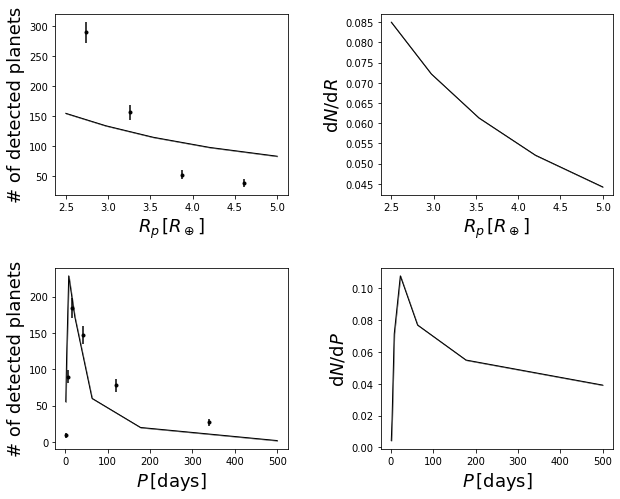

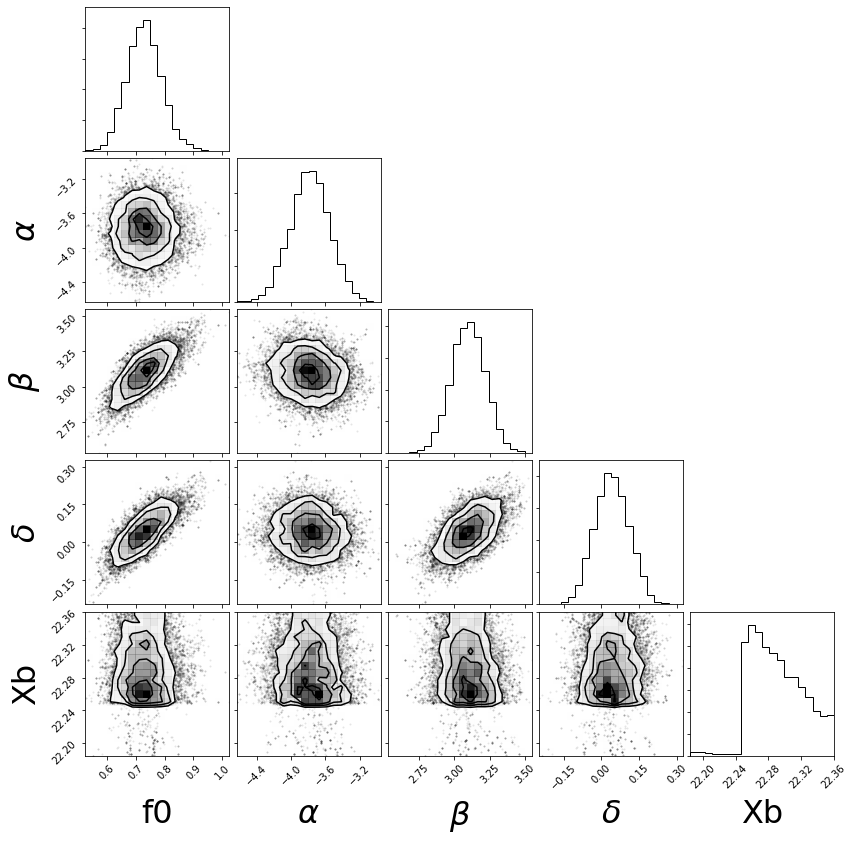

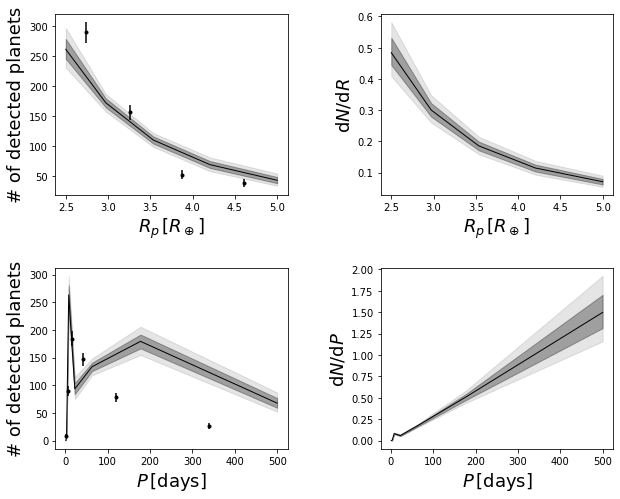

In [17]:
model = "brokenPowerLawY"
r = firstCheck(model)
brokenPower_noRel = noReliability(model, r)

brokenPowerLawY


FloatProgress(value=0.0, max=50.0)

/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: divide by zero encountered in log
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/emcee/ensemble.py:253: RuntimeWarning: Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance
  category=RuntimeWarning,


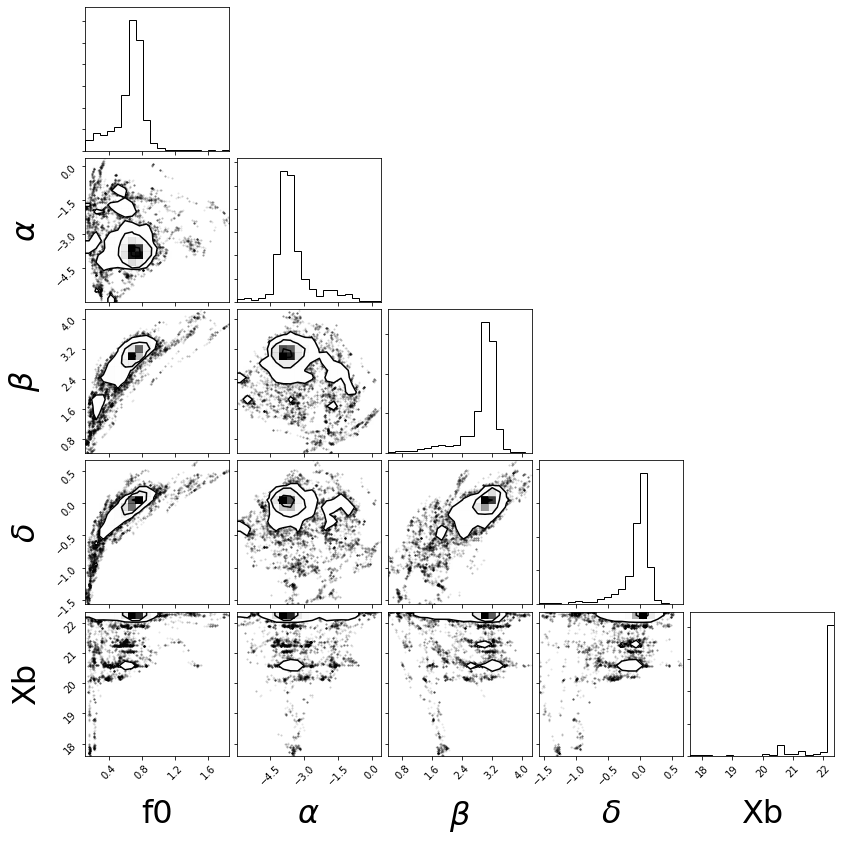

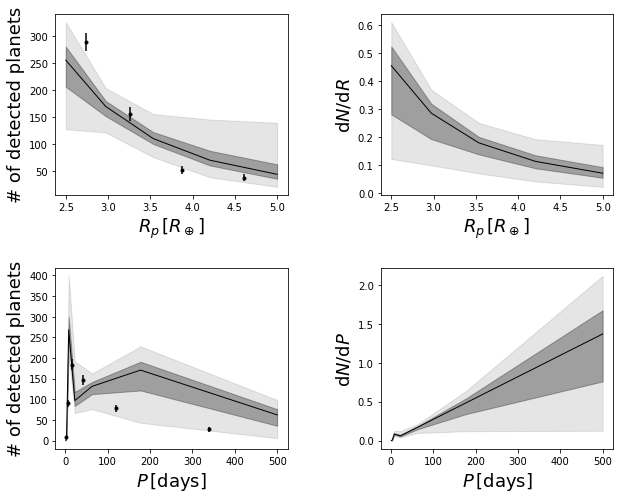

In [18]:
brokenPower_wRel = wReliability(model, kois)

kneeXpowerY
[0.75, -2.0, 0.5, -1, 10]
4137.231404123588


/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: divide by zero encountered in log


[ 0.40230291 -3.6556925   1.27810675 -2.1696778  11.90211707]
kneeXpowerY


/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:48: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:48: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


--- 54.443804025650024 seconds ---


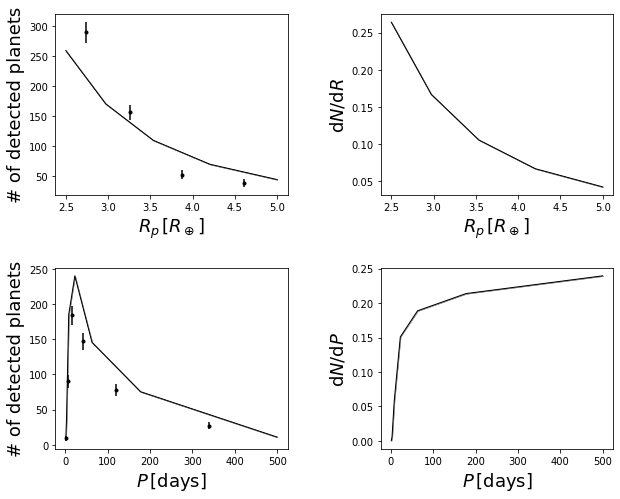

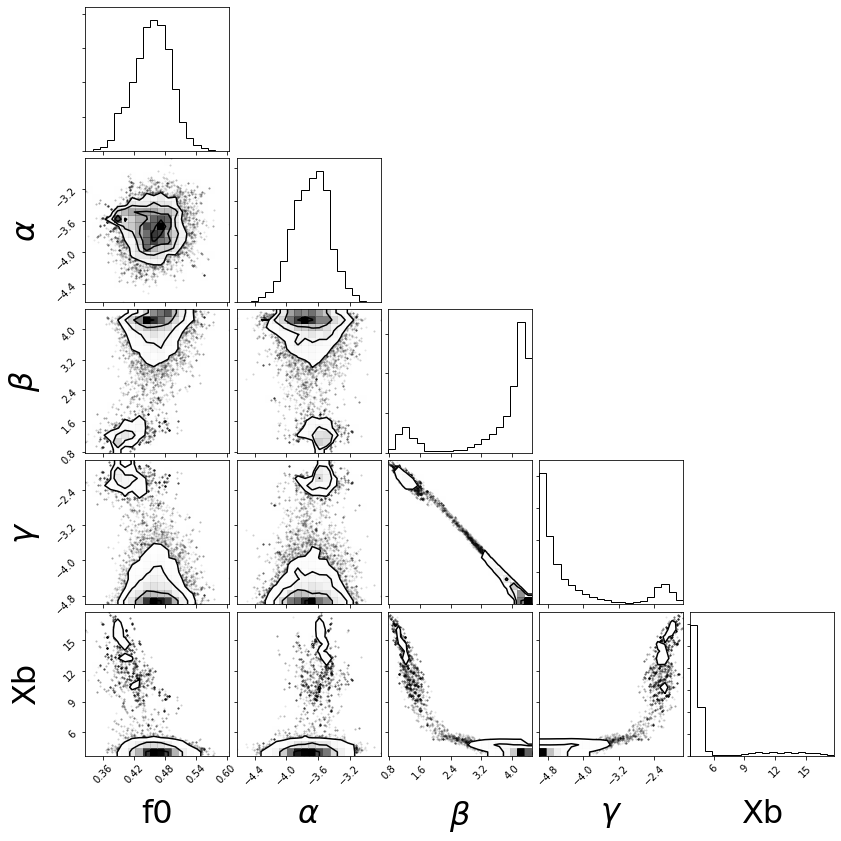

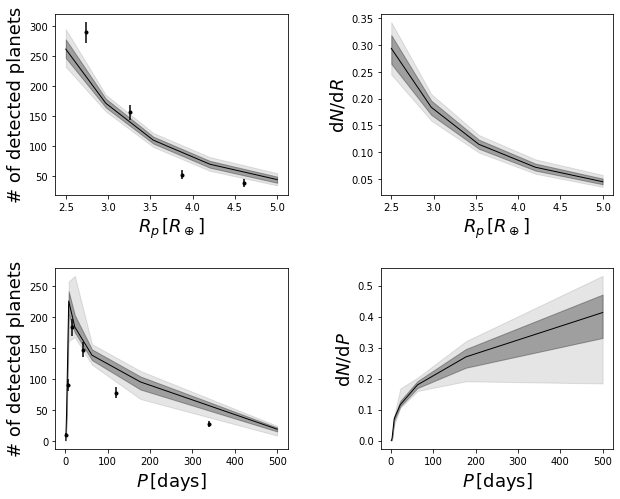

In [19]:
model = "kneeXpowerY"
r = firstCheck(model)
kneePower_noRel = noReliability(model, r)

kneeXpowerY


FloatProgress(value=0.0, max=50.0)

/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: divide by zero encountered in log
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:48: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:48: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


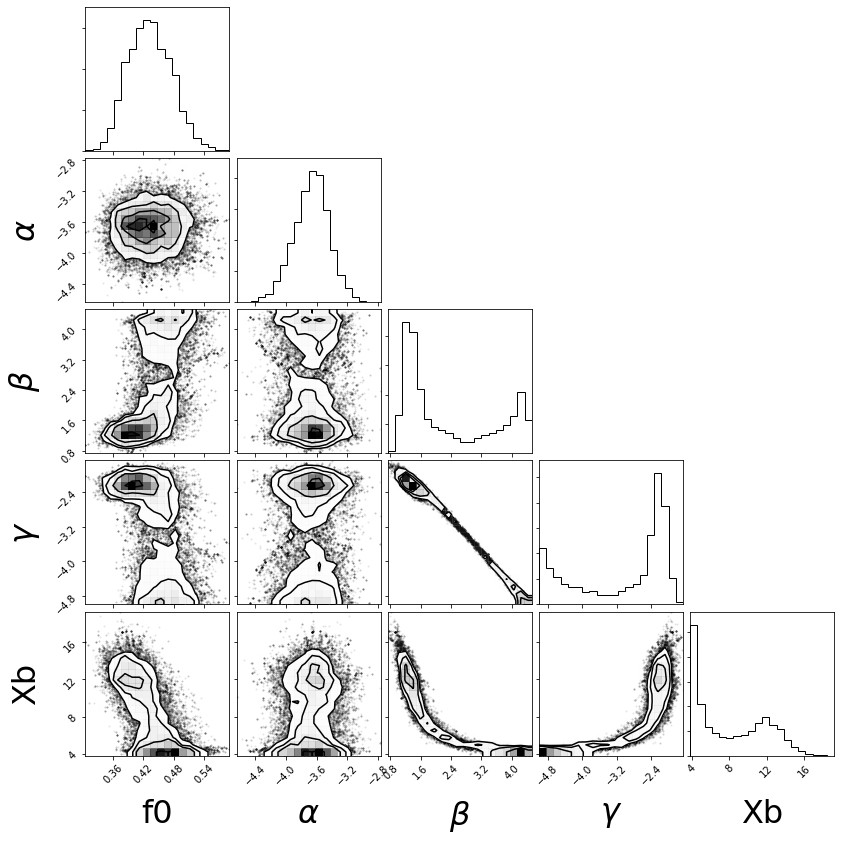

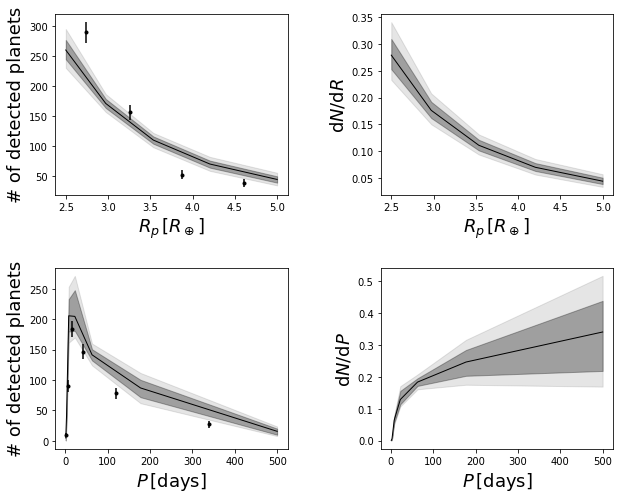

In [20]:
kneePower_wRel = wReliability(model, kois)

kneeXgenLogisticY
[0.75, 0.5, 0.5, -1, 10, 1, 1]
4154.373933201519


/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: divide by zero encountered in log
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:60: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in power


[ 0.41684358  1.25299263  1.28386762 -2.07680745 10.28658203  0.07100276
  0.88182634]
kneeXgenLogisticY


/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:57: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:57: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:60: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yield

--- 61.278844118118286 seconds ---


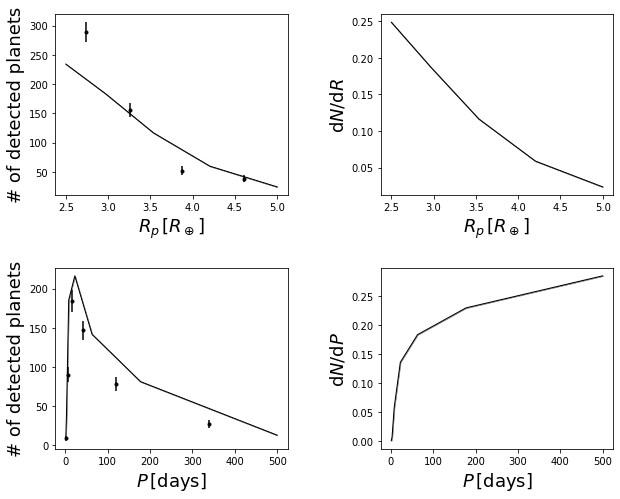

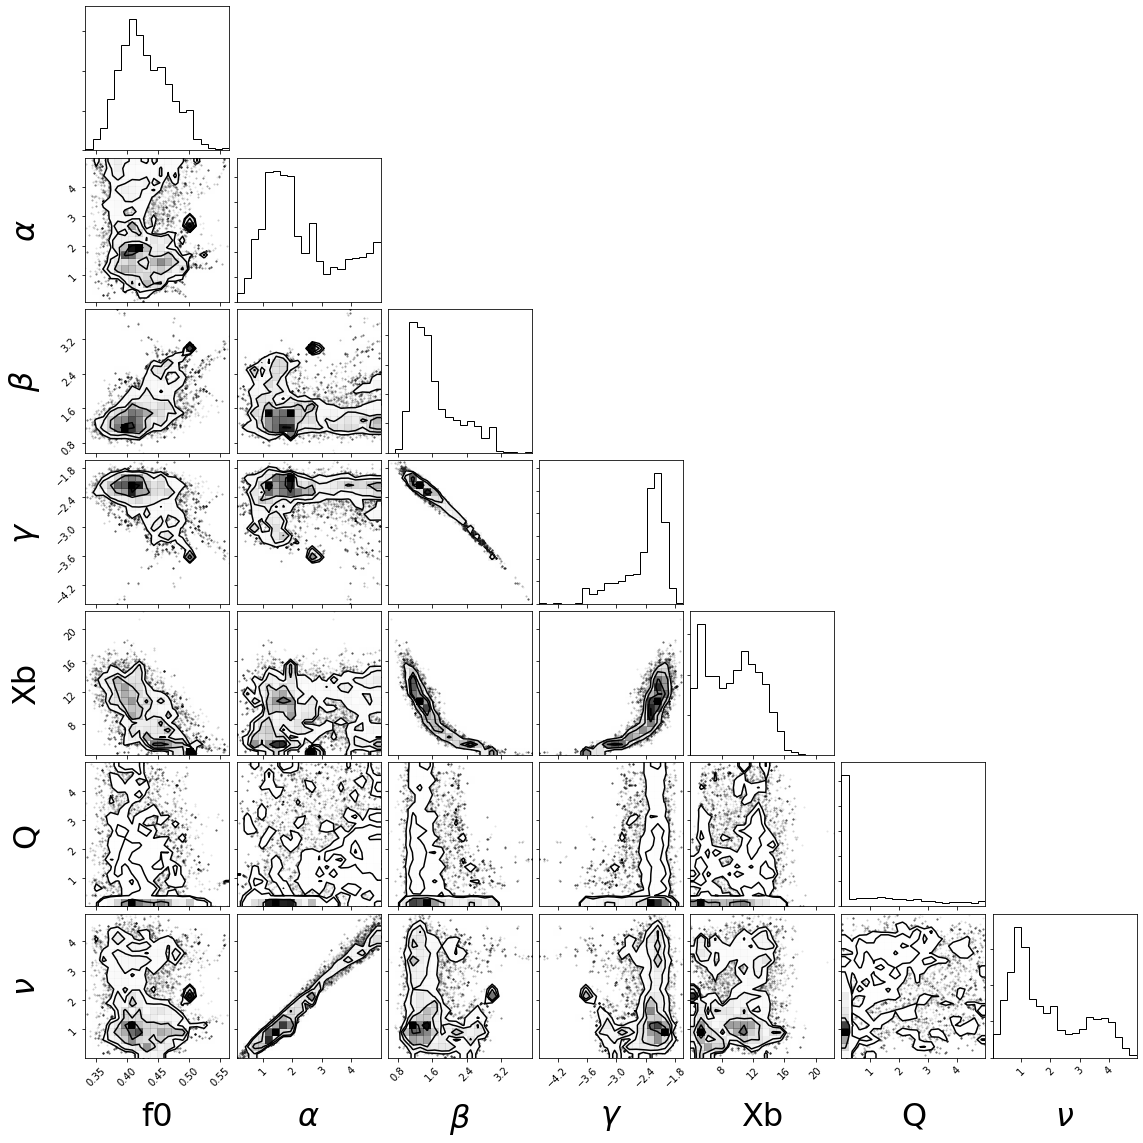

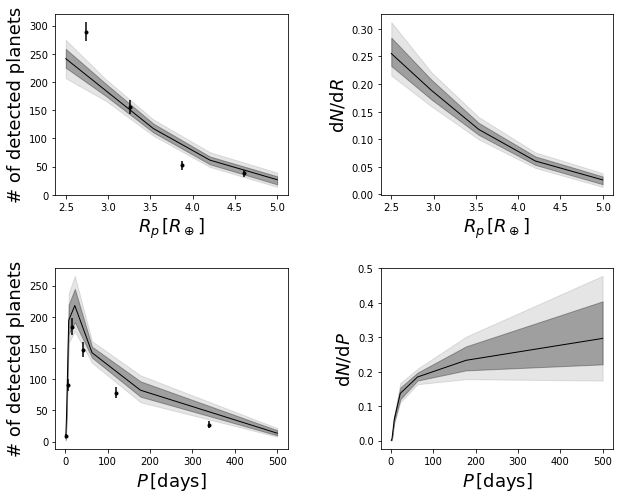

In [21]:
model = "kneeXgenLogisticY"
r = firstCheck(model)
kneegenLogPower_noRel = noReliability(model, r)

In [ ]:
kneegenLog_wRel = wReliability(model, kois)

kneeXgenLogisticY


FloatProgress(value=0.0, max=50.0)

/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:354: RuntimeWarning: divide by zero encountered in log
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:60: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in power
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:60: IntegrationWarning: The max

In [ ]:
model = "kneeXLogisticY2"
r = firstCheck(model)
kneeLog2Power_noRel = noReliability(model, r)

In [ ]:
kneeLog2_wRel = wReliability(model, kois)

In [ ]:
model = "kneeXLogisticY3"
r = firstCheck(model)
kneeLog3Power_noRel = noReliability(model, r)

In [ ]:
kneeLog3_wRel = wReliability(model, kois)

In [ ]:
model = "kneeXLogisticY4"
r = firstCheck(model)
kneeLog4Power_noRel = noReliability(model, r)

In [ ]:
kneeLog4_wRel = wReliability(model, kois)

In [ ]:
model = "kneeXLogisticY5"
r = firstCheck(model)
kneeLog5Power_noRel = noReliability(model, r)

In [ ]:
model = "kneeXgaussY"
r = firstCheck(model)
kneeGaussPower_noRel = noReliability(model, r)

In [ ]:
kneeGauss_wRel = wReliability(model, kois)

In [ ]:
def calc_AIC(samples):
    L = [lnlike(p) for i,p in enumerate(samples)]
    #L[np.isinf(L)] = np.nan
    plt.figure()
    plt.hist(L, bins=100);

    aicDist = 2*samples.shape[1] - 2*np.array(L)
    plt.figure()
    plt.hist(aicDist, bins=100);
    plt.show()

    minAIC = min(aicDist)
    return(minAIC)

In [ ]:
model = "dualPowerLaw"
print(model)
dualPowerAIC = calc_AIC(dualPower_wRel)
model = "brokenPowerLawY"
print(model)
brokenPowerAIC = calc_AIC(brokenPower_wRel)
model = "kneeXpowerY"
print(model)
kneePowerAIC = calc_AIC(kneePower_wRel)
model = "kneeXgenLogisticY"
print(model)
kneegenLogAIC = calc_AIC(kneegenLog_wRel)
model = "kneeXLogisticY2"
print(model)
kneeLog2AIC = calc_AIC(kneeLog2_wRel)
model = "kneeXLogisticY3"
print(model)
kneeLog3AIC = calc_AIC(kneeLog3_wRel)
model = "kneeXLogisticY4"
print(model)
kneeLog4AIC = calc_AIC(kneeLog4_wRel)
model = "kneeXgaussY"
kneeGaussAIC = calc_AIC(kneeGauss_wRel)

print(dualPowerAIC, brokenPowerAIC, kneePowerAIC, kneegenLogAIC, kneeLog2AIC, kneeLog3AIC, kneeLog4AIC, kneeGaussAIC)

In [ ]:
from scipy.interpolate import griddata
points = np.array(list(zip(period_grid.flatten(), rp_grid.flatten())))
values = summedCompleteness.flatten()

pc = np.array(list(zip(kois.koi_period.values, getRadii(kois).values)))

grid = griddata(points, values, pc, method='linear')

In [ ]:
kois['completeness'] = grid/ kiclist.size
kois['kois_rp'] = getRadii(kois)

In [ ]:
exp = np.zeros((len(period)-1, len(rp)-1))
w = np.zeros((len(period)-1, len(rp)-1))

for i in range(len(period)-1):
    for j in range(len(rp)-1):
        bin_ = kois[((kois.koi_period < period[i+1]) & (kois.koi_period > period[i]) & 
                     (kois.kois_rp < rp[j+1]) & (kois.kois_rp > rp[j]))]
        exp[i, j] = np.sum(bin_.totalReliability / bin_.completeness)
        
        w[i, j] = trapz(trapz(summedProbDet[i:i+2, j:j+2]/kiclist.size, dx=1), dx=1)

occ = exp / kiclist.size

In [ ]:
c = np.zeros((len(period)-1, len(rp)-1))
H[H == 0.0] = -0.999
occ_upper = occ.copy()
c[H < 0] = 1
summedCompleteness_c = 0.5*(summedCompleteness[1:, 1:] + summedCompleteness[:-1, :-1])
occ_upper[occ == 0.] = 1 / summedCompleteness_c[np.where(occ == 0.)]

weighted_occ = occ_upper / w

In [ ]:
exp_w = exp / w
err = np.sqrt(np.abs(H)) * exp_w / (kiclist.size * np.abs(H))

fig, ax = plt.subplots(figsize=(20, 10))
im = ax.pcolormesh(period_grid, rp_grid, weighted_occ, cmap='cool')
for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        t = str("%.5f" % weighted_occ.T[i,j]) + '\n' + r" $\pm$ " + str("%.5f" % err.T[i,j]) + '\n num: ' + str(H.T[i,j])
        if H.T[i,j]<0:
            ax.text(xcent[j], ycent[i], t, 
                color="r", ha="center", va="center", fontsize=12)
        else:
            ax.text(xcent[j], ycent[i], t, 
                color="k", ha="center", va="center", fontsize=12)

ax.tick_params(axis='both', labelsize='large')
               
plt.colorbar(im, label="Occurrence")
plt.xlabel("Period", fontsize=14)
plt.ylabel("Radius", fontsize=14)
plt.xscale('log')
plt.yscale('log')

plt.show()

In [ ]:
co_period = np.empty(np.sum(c, axis=1).shape, dtype=str)
co_period[np.sum(c, axis=1) == 0] = 'k'
co_period[np.sum(c, axis=1) >= 1.] = 'r'

co_rad = np.empty(np.sum(c, axis=0).shape, dtype=str)
co_rad[np.sum(c, axis=0) == 0] = 'k'
co_rad[np.sum(c, axis=0) >= 1.] = 'r'

p_cent = 0.5* (period[1:] + period[:-1])
r_cent = 0.5* (rp[1:] + rp[:-1])

err2 = err**2

In [ ]:
plt.figure()
plt.plot(r_cent, np.sum(occ_upper, axis=0), '.')
plt.scatter(r_cent, np.sum(weighted_occ, axis=0), marker='.', color='k', label="IDEM")
plt.errorbar(r_cent, np.sum(weighted_occ, axis=0), yerr=np.sqrt(np.sum(err2, axis=0)), fmt='k.', ecolor=co_rad)
plt.xscale('log')

plt.figure()
plt.plot(p_cent, np.sum(occ_upper, axis=1), '.')
plt.scatter(p_cent, np.sum(weighted_occ, axis=1), marker='.', color='k', label="IDEM")
plt.errorbar(p_cent, np.sum(weighted_occ, axis=1), yerr=np.sqrt(np.sum(err2, axis=1)), fmt='k.', ecolor=co_period)

plt.show()

In [ ]:
def recreate(pg, rg, prng, rrng, pbins, rbins, samples, model, comp, cplt=False):
    samples = np.atleast_2d(samples)
    pop = np.empty((len(samples), pg.shape[0], pg.shape[1]))
    for i, p in enumerate(samples):
        pop[i] = rateModel(pg, rg, prng, rrng, p, model)
    #pop = rateModel(pg, rg, prng, rrng, sample, model)
    if cplt:
        pop = pop * comp[None, :, :]
        alt_pop = np.swapaxes(pop, 1, 2)
    else:
        #pop = pop[None, :, :]
        alt_pop = np.swapaxes(pop, 1, 2)
    
    pop = trapz(pop, x=pbins, axis=1)
    alt_pop = trapz(alt_pop, x=rbins, axis=1)
    
    x = np.append(np.diff(rbins), rp_q)
    y = np.append(np.diff(pbins), period_q)
    
    r = np.percentile(pop * x, [2.5, 16, 50, 84, 97.5], axis=0)
    p = np.percentile(alt_pop * y, [2.5, 16, 50, 84, 97.5], axis=0)
    return(r, p)

In [ ]:
#(dualPowerAIC, brokenPowerAIC, kneePowerAIC, kneegenLogAIC, kneeLog2AIC, kneeLog3AIC, kneeLog4AIC, kneeGaussAIC)

In [ ]:
dualPower_rad, dualPower_per = recreate(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                                         dualPower_wRel, "dualPowerLaw", summedCompleteness)
dualPower_rad_num, dualPower_per_num = recreate(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                                                 dualPower_wRel, "dualPowerLaw", summedCompleteness, cplt=True)

brokenPower_rad, brokenPower_per = recreate(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                                         brokenPower_wRel, "brokenPowerLawY", summedCompleteness)
brokenPower_rad_num, brokenPower_per_num = recreate(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                                                 brokenPower_wRel, "brokenPowerLawY", summedCompleteness, cplt=True)

kneePower_rad, kneePower_per = recreate(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                                         kneePower_wRel, "kneeXpowerY", summedCompleteness)
kneePower_rad_num, kneePower_per_num = recreate(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                                                 kneePower_wRel, "kneeXpowerY", summedCompleteness, cplt=True)

kneeGauss_rad, kneeGauss_per = recreate(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                                         kneeGauss_wRel, "kneeXgaussY", summedCompleteness)
kneeGauss_rad_num, kneeGauss_per_num = recreate(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                                                 kneeGauss_wRel, "kneeXgaussY", summedCompleteness, cplt=True)

In [ ]:
kneegenLog_rad, kneegenLog_per = recreate(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                                         kneegenLog_wRel, "kneeXgenLogisticY", summedCompleteness)
kneegenLog_rad_num, kneegenLog_per_num = recreate(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                                                 kneegenLog_wRel, "kneeXgenLogisticY", summedCompleteness, cplt=True)

kneeLog2_rad, kneeLog2_per = recreate(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                                         kneeLog2_wRel, "kneeXLogisticY2", summedCompleteness)
kneeLog2_rad_num, kneeLog2_per_num = recreate(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                                                 kneeLog2_wRel, "kneeXLogisticY2", summedCompleteness, cplt=True)

kneeLog3_rad, kneeLog3_per = recreate(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                                         kneeLog3_wRel, "kneeXLogisticY3", summedCompleteness)
kneeLog3_rad_num, kneeLog3_per_num = recreate(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                                                 kneeLog3_wRel, "kneeXLogisticY3", summedCompleteness, cplt=True)

kneeLog4_rad, kneeLog4_per = recreate(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                                         kneeLog4_wRel, "kneeXLogisticY4", summedCompleteness)
kneeLog4_rad_num, kneeLog4_per_num = recreate(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                                                 kneeLog4_wRel, "kneeXLogisticY4", summedCompleteness, cplt=True)

In [ ]:
dualPower_rad_num_c = 0.5*(dualPower_rad_num[2][1:] + dualPower_rad_num[2][:-1])
dualPower_rad_res = dualPower_rad_num_c - np.sum(H, axis=0)
dualPower_per_num_c = 0.5*(dualPower_per_num[2][1:] + dualPower_per_num[2][:-1])
dualPower_per_res = dualPower_per_num_c - np.sum(H, axis=1)

plt.figure()
plt.scatter(r_cent, dualPower_rad_res)
plt.axhline(y=0)
plt.xscale('log')

plt.figure()
plt.scatter(p_cent, dualPower_per_res)
plt.axhline(y=0)
plt.xscale('log')
plt.show()

In [ ]:
dualPower_rad_num_c = 0.5*(dualPower_rad_num[2][1:] + dualPower_rad_num[2][:-1])
dualPower_rad_res = dualPower_rad_num_c - np.sum(H, axis=0)
dualPower_per_num_c = 0.5*(dualPower_per_num[2][1:] + dualPower_per_num[2][:-1])
dualPower_per_res = dualPower_per_num_c - np.sum(H, axis=1)

brokenPower_rad_num_c = 0.5*(brokenPower_rad_num[2][1:] + brokenPower_rad_num[2][:-1])
brokenPower_rad_res = brokenPower_rad_num_c - np.sum(H, axis=0)
brokenPower_per_num_c = 0.5*(brokenPower_per_num[2][1:] + brokenPower_per_num[2][:-1])
brokenPower_per_res = brokenPower_per_num_c - np.sum(H, axis=1)

kneePower_rad_num_c = 0.5*(kneePower_rad_num[2][1:] + kneePower_rad_num[2][:-1])
kneePower_rad_res = kneePower_rad_num_c - np.sum(H, axis=0)
kneePower_per_num_c = 0.5*(kneePower_per_num[2][1:] + kneePower_per_num[2][:-1])
kneePower_per_res = kneePower_per_num_c - np.sum(H, axis=1)

kneeGauss_rad_num_c = 0.5*(kneeGauss_rad_num[2][1:] + kneeGauss_rad_num[2][:-1])
kneeGauss_rad_res = kneeGauss_rad_num_c - np.sum(H, axis=0)
kneeGauss_per_num_c = 0.5*(kneeGauss_per_num[2][1:] + kneeGauss_per_num[2][:-1])
kneeGauss_per_res = kneeGauss_per_num_c - np.sum(H, axis=1)

In [ ]:
kneegenLog_rad_num_c = 0.5*(kneegenLog_rad_num[2][1:] + kneegenLog_rad_num[2][:-1])
kneegenLog_rad_res = kneegenLog_rad_num_c - np.sum(H, axis=0)
kneegenLog_per_num_c = 0.5*(kneegenLog_per_num[2][1:] + kneegenLog_per_num[2][:-1])
kneegenLog_per_res = kneegenLog_per_num_c - np.sum(H, axis=1)

kneeLog2_rad_num_c = 0.5*(kneeLog2_rad_num[2][1:] + kneeLog2_rad_num[2][:-1])
kneeLog2_rad_res = kneeLog2_rad_num_c - np.sum(H, axis=0)
kneeLog2_per_num_c = 0.5*(kneeLog2_per_num[2][1:] + kneeLog2_per_num[2][:-1])
kneeLog2_per_res = kneeLog2_per_num_c - np.sum(H, axis=1)

kneeLog3_rad_num_c = 0.5*(kneeLog3_rad_num[2][1:] + kneeLog3_rad_num[2][:-1])
kneeLog3_rad_res = kneeLog3_rad_num_c - np.sum(H, axis=0)
kneeLog3_per_num_c = 0.5*(kneeLog3_per_num[2][1:] + kneeLog3_per_num[2][:-1])
kneeLog3_per_res = kneeLog3_per_num_c - np.sum(H, axis=1)

kneeLog4_rad_num_c = 0.5*(kneeLog4_rad_num[2][1:] + kneeLog4_rad_num[2][:-1])
kneeLog4_rad_res = kneeLog4_rad_num_c - np.sum(H, axis=0)
kneeLog4_per_num_c = 0.5*(kneeLog4_per_num[2][1:] + kneeLog4_per_num[2][:-1])
kneeLog4_per_res = kneeLog4_per_num_c - np.sum(H, axis=1)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].fill_between(period, dualPower_per_num[0], dualPower_per_num[4], color="g", alpha=0.1, edgecolor="none")
axs[0, 0].fill_between(period, dualPower_per_num[1], dualPower_per_num[3], color="g", alpha=0.3, edgecolor="none")
axs[0, 0].plot(period, dualPower_per_num[2], color='g')
axs[0, 0].errorbar(p_cent, np.sum(H, axis=1), yerr=np.sqrt(np.sum(H, axis=1)), fmt=".k", label='observed in Kepler')
axs[0, 0].set_xlabel('Period', fontsize=14)
axs[0, 0].set_ylabel('# detected', fontsize=14)
axs[0, 0].set_xscale('log')
axs[0, 0].text(1, 150, s="dualPower\n AIC: %.2f" % dualPowerAIC)

axs[0, 1].fill_between(period, brokenPower_per_num[0], brokenPower_per_num[4], color="g", alpha=0.1, edgecolor="none")
axs[0, 1].fill_between(period, brokenPower_per_num[1], brokenPower_per_num[3], color="g", alpha=0.3, edgecolor="none")
axs[0, 1].plot(period, brokenPower_per_num[2], color='g')
axs[0, 1].errorbar(p_cent, np.sum(H, axis=1), yerr=np.sqrt(np.sum(H, axis=1)), fmt=".k", label='observed in Kepler')
axs[0, 1].set_xlabel('Period', fontsize=14)
axs[0, 1].set_ylabel('# detected', fontsize=14)
axs[0, 1].set_xscale('log')
axs[0, 1].text(1, 350, s="brokenPower\n AIC: %.2f" % brokenPowerAIC)

axs[1, 0].fill_between(period, kneePower_per_num[0], kneePower_per_num[4], color="g", alpha=0.1, edgecolor="none")
axs[1, 0].fill_between(period, kneePower_per_num[1], kneePower_per_num[3], color="g", alpha=0.3, edgecolor="none")
axs[1, 0].plot(period, kneePower_per_num[2], color='g')
axs[1, 0].errorbar(p_cent, np.sum(H, axis=1), yerr=np.sqrt(np.sum(H, axis=1)), fmt=".k", label='observed in Kepler')
axs[1, 0].set_xlabel('Period', fontsize=14)
axs[1, 0].set_ylabel('# detected', fontsize=14)
axs[1, 0].set_xscale('log')
axs[1, 0].text(1, 175, s="kneePower\n AIC:8 %.2f" % kneePowerAIC)

axs[1, 1].fill_between(period, kneeGauss_per_num[0], kneeGauss_per_num[4], color="g", alpha=0.1, edgecolor="none")
axs[1, 1].fill_between(period, kneeGauss_per_num[1], kneeGauss_per_num[3], color="g", alpha=0.3, edgecolor="none")
axs[1, 1].plot(period, kneeGauss_per_num[2], color='g')
axs[1, 1].errorbar(p_cent, np.sum(H, axis=1), yerr=np.sqrt(np.sum(H, axis=1)), fmt=".k", label='observed in Kepler')
axs[1, 1].set_xlabel('Period', fontsize=14)
axs[1, 1].set_ylabel('# detected', fontsize=14)
axs[1, 1].set_xscale('log')
axs[1, 1].text(1, 175, s="kneeGauss\n AIC: %.2f" % kneeGaussAIC)


fig, axs = plt.subplots(2, 2, sharex='col', figsize=(12, 10))

axs[0, 0].scatter(p_cent, dualPower_per_res)
axs[0, 0].axhline(y=0)
axs[0, 0].set_xscale('log')
axs[0, 0].text(10, 60, s="dualPower\n sum: %.3f" % np.sum(np.abs(dualPower_per_res)))

axs[0, 1].scatter(p_cent, brokenPower_per_res)
axs[0, 1].axhline(y=0)
axs[0, 1].set_xscale('log')
axs[0, 1].text(70, 60, s="brokenPower\n sum: %.3f" % np.sum(np.abs(brokenPower_per_res)))

axs[1, 0].scatter(p_cent, kneePower_per_res)
axs[1, 0].axhline(y=0)
axs[1, 0].set_xscale('log')
axs[1, 0].text(70, 30, s="kneePower\n sum: %.3f" % np.sum(np.abs(kneePower_per_res)))

axs[1, 1].scatter(p_cent, kneeGauss_per_res)
axs[1, 1].axhline(y=0)
axs[1, 1].set_xscale('log')
axs[1, 1].text(70, 30, s="kneeGauss\n sum: %.3f" % np.sum(np.abs(kneeGauss_per_res)))

"""plt.figure()
plt.plot(p_cent, dualPower_per_res)
plt.plot(p_cent, brokenPower_per_res)
plt.plot(p_cent, kneePower_per_res)
plt.plot(p_cent, kneeGauss_per_res)
plt.show()"""

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].fill_between(rp, dualPower_rad_num[0], dualPower_rad_num[4], color="g", alpha=0.1, edgecolor="none")
axs[0, 0].fill_between(rp, dualPower_rad_num[1], dualPower_rad_num[3], color="g", alpha=0.3, edgecolor="none")
axs[0, 0].plot(rp, dualPower_rad_num[2], color='g')
axs[0, 0].errorbar(r_cent, np.sum(H, axis=0), yerr=np.sqrt(np.sum(H, axis=0)), fmt=".k", label='observed in Kepler')
axs[0, 0].set_xlabel('radius', fontsize=14)
axs[0, 0].set_ylabel('# detected', fontsize=14)
axs[0, 0].set_xscale('log')
axs[0, 0].text(4, 150, s="dualPower\n AIC: %.2f" % dualPowerAIC)

axs[0, 1].fill_between(rp, brokenPower_rad_num[0], brokenPower_rad_num[4], color="g", alpha=0.1, edgecolor="none")
axs[0, 1].fill_between(rp, brokenPower_rad_num[1], brokenPower_rad_num[3], color="g", alpha=0.3, edgecolor="none")
axs[0, 1].plot(rp, brokenPower_rad_num[2], color='g')
axs[0, 1].errorbar(r_cent, np.sum(H, axis=0), yerr=np.sqrt(np.sum(H, axis=0)), fmt=".k", label='observed in Kepler')
axs[0, 1].set_xlabel('radius', fontsize=14)
axs[0, 1].set_ylabel('# detected', fontsize=14)
axs[0, 1].set_xscale('log')
axs[0, 1].text(4, 200, s="brokenPower\n AIC: %.2f" % brokenPowerAIC)

axs[1, 0].fill_between(rp, kneePower_rad_num[0], kneePower_rad_num[4], color="g", alpha=0.1, edgecolor="none")
axs[1, 0].fill_between(rp, kneePower_rad_num[1], kneePower_rad_num[3], color="g", alpha=0.3, edgecolor="none")
axs[1, 0].plot(rp, kneePower_rad_num[2], color='g')
axs[1, 0].errorbar(r_cent, np.sum(H, axis=0), yerr=np.sqrt(np.sum(H, axis=0)), fmt=".k", label='observed in Kepler')
axs[1, 0].set_xlabel('radius', fontsize=14)
axs[1, 0].set_ylabel('# detected', fontsize=14)
axs[1, 0].set_xscale('log')
axs[1, 0].text(4, 175, s="kneePower\n AIC: %.2f" % kneePowerAIC)

axs[1, 1].fill_between(rp, kneeGauss_rad_num[0], kneeGauss_rad_num[4], color="g", alpha=0.1, edgecolor="none")
axs[1, 1].fill_between(rp, kneeGauss_rad_num[1], kneeGauss_rad_num[3], color="g", alpha=0.3, edgecolor="none")
axs[1, 1].plot(rp, kneeGauss_rad_num[2], color='g')
axs[1, 1].errorbar(r_cent, np.sum(H, axis=0), yerr=np.sqrt(np.sum(H, axis=0)), fmt=".k", label='observed in Kepler')
axs[1, 1].set_xlabel('radius', fontsize=14)
axs[1, 1].set_ylabel('# detected', fontsize=14)
axs[1, 1].set_xscale('log')
axs[1, 1].text(4, 175, s="kneeGauss\n AIC:8985.9")



fig, axs = plt.subplots(2, 2, sharex='col', figsize=(12, 10))

axs[0, 0].scatter(r_cent, dualPower_rad_res)
axs[0, 0].axhline(y=0)
axs[0, 0].set_xscale('log')
axs[0, 0].text(4, -10, s="dualPower\n sum: %.3f" % np.sum(np.abs(dualPower_rad_res)))

axs[0, 1].scatter(r_cent, brokenPower_rad_res)
axs[0, 1].axhline(y=0)
axs[0, 1].set_xscale('log')
axs[0, 1].text(4, -10, s="brokenPower\n sum: %.3f" % np.sum(np.abs(brokenPower_rad_res)))

axs[1, 0].scatter(r_cent, kneePower_rad_res)
axs[1, 0].axhline(y=0)
axs[1, 0].set_xscale('log')
axs[1, 0].text(4, -10, s="kneePower\n sum: %.3f" % np.sum(np.abs(kneePower_rad_res)))

axs[1, 1].scatter(r_cent, kneeGauss_rad_res)
axs[1, 1].axhline(y=0)
axs[1, 1].set_xscale('log')
axs[1, 1].text(4, -20, s="kneeGauss\n sum: %.3f" % np.sum(np.abs(kneeGauss_rad_res)))

"""plt.figure()
plt.plot(r_cent, dualPower_rad_res)
plt.plot(r_cent, brokenPower_rad_res)
plt.plot(r_cent, kneePower_rad_res)
plt.plot(r_cent, kneeGauss_rad_res)
plt.show()"""

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].fill_between(period, kneegenLog_per_num[0], kneegenLog_per_num[4], color="g", alpha=0.1, edgecolor="none")
axs[0, 0].fill_between(period, kneegenLog_per_num[1], kneegenLog_per_num[3], color="g", alpha=0.3, edgecolor="none")
axs[0, 0].plot(period, kneegenLog_per_num[2], color='g')
axs[0, 0].errorbar(p_cent, np.sum(H, axis=1), yerr=np.sqrt(np.sum(H, axis=1)), fmt=".k", label='observed in Kepler')
axs[0, 0].set_xlabel('Period', fontsize=14)
axs[0, 0].set_ylabel('# detected', fontsize=14)
axs[0, 0].set_xscale('log')
axs[0, 0].text(10, 1, s="kneegenLog\n AIC: %.2f" % kneegenLogAIC)

#axs[0, 1].fill_between(period, kneeLog2_per_num[0], kneeLog2_per_num[4], color="g", alpha=0.1, edgecolor="none")
axs[0, 1].fill_between(period, kneeLog2_per_num[1], kneeLog2_per_num[3], color="g", alpha=0.3, edgecolor="none")
axs[0, 1].plot(period, kneeLog2_per_num[2], color='g')
axs[0, 1].errorbar(p_cent, np.sum(H, axis=1), yerr=np.sqrt(np.sum(H, axis=1)), fmt=".k", label='observed in Kepler')
axs[0, 1].set_xlabel('Period', fontsize=14)
axs[0, 1].set_ylabel('# detected', fontsize=14)
axs[0, 1].set_xscale('log')
axs[0, 1].text(10, 1, s="kneeLog2\n AIC: %.2f" % kneeLog2AIC)

axs[1, 0].fill_between(period, kneeLog3_per_num[0], kneeLog3_per_num[4], color="g", alpha=0.1, edgecolor="none")
axs[1, 0].fill_between(period, kneeLog3_per_num[1], kneeLog3_per_num[3], color="g", alpha=0.3, edgecolor="none")
axs[1, 0].plot(period, kneeLog3_per_num[2], color='g')
axs[1, 0].errorbar(p_cent, np.sum(H, axis=1), yerr=np.sqrt(np.sum(H, axis=1)), fmt=".k", label='observed in Kepler')
axs[1, 0].set_xlabel('Period', fontsize=14)
axs[1, 0].set_ylabel('# detected', fontsize=14)
axs[1, 0].set_xscale('log')
axs[1, 0].text(10, 1, s="kneeLog3\n AIC: %.2f" % kneeLog3AIC)

axs[1, 1].fill_between(period, kneeLog4_per_num[0], kneeLog4_per_num[4], color="g", alpha=0.1, edgecolor="none")
axs[1, 1].fill_between(period, kneeLog4_per_num[1], kneeLog4_per_num[3], color="g", alpha=0.3, edgecolor="none")
axs[1, 1].plot(period, kneeLog4_per_num[2], color='g')
axs[1, 1].errorbar(p_cent, np.sum(H, axis=1), yerr=np.sqrt(np.sum(H, axis=1)), fmt=".k", label='observed in Kepler')
axs[1, 1].set_xlabel('Period', fontsize=14)
axs[1, 1].set_ylabel('# detected', fontsize=14)
axs[1, 1].set_xscale('log')
axs[1, 1].text(10, 1, s="kneeLog4\n AIC: %.2f" % kneeLog4AIC)

fig, axs = plt.subplots(2, 2, sharex='col', figsize=(12, 10))

axs[0, 0].scatter(p_cent, kneegenLog_per_res)
axs[0, 0].axhline(y=0)
axs[0, 0].set_xscale('log')
axs[0, 0].text(100, 30, s="kneegenLog\n sum: %.3f" % np.sum(np.abs(kneegenLog_per_res)))

axs[0, 1].scatter(p_cent, kneeLog2_per_res)
axs[0, 1].axhline(y=0)
axs[0, 1].set_xscale('log')
axs[0, 1].text(100, 30, s="kneeLog2\n sum: %.3f" % np.sum(np.abs(kneeLog2_per_res)))

axs[1, 0].scatter(p_cent, kneeLog3_per_res)
axs[1, 0].axhline(y=0)
axs[1, 0].set_xscale('log')
axs[1, 0].text(100, 30, s="kneeLog3\n sum: %.3f" % np.sum(np.abs(kneeLog3_per_res)))

axs[1, 1].scatter(p_cent, kneeLog4_per_res)
axs[1, 1].axhline(y=0)
axs[1, 1].set_xscale('log')
axs[1, 1].text(100, 30, s="kneeLog4\n sum: %.3f" % np.sum(np.abs(kneeLog4_per_res)))
"""
plt.figure()
plt.plot(p_cent, kneegenLog_per_res)
plt.plot(p_cent, kneeLog2_per_res)
plt.plot(p_cent, kneeLog3_per_res)
plt.plot(p_cent, kneeLog4_per_res)
plt.show()
"""

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].fill_between(rp, kneegenLog_rad_num[0], kneegenLog_rad_num[4], color="g", alpha=0.1, edgecolor="none")
axs[0, 0].fill_between(rp, kneegenLog_rad_num[1], kneegenLog_rad_num[3], color="g", alpha=0.3, edgecolor="none")
axs[0, 0].plot(rp, kneegenLog_rad_num[2], color='g')
axs[0, 0].errorbar(r_cent, np.sum(H, axis=0), yerr=np.sqrt(np.sum(H, axis=0)), fmt=".k", label='observed in Kepler')
axs[0, 0].set_xlabel('radius', fontsize=14)
axs[0, 0].set_ylabel('# detected', fontsize=14)
axs[0, 0].set_xscale('log')
axs[0, 0].text(4, 150, s="kneegenLog\n AIC: %.2f" % kneegenLogAIC)

#axs[0, 1].fill_between(rp, kneeLog2_rad_num[0], kneeLog2_rad_num[4], color="g", alpha=0.1, edgecolor="none")
axs[0, 1].fill_between(rp, kneeLog2_rad_num[1], kneeLog2_rad_num[3], color="g", alpha=0.3, edgecolor="none")
axs[0, 1].plot(rp, kneeLog2_rad_num[2], color='g')
axs[0, 1].errorbar(r_cent, np.sum(H, axis=0), yerr=np.sqrt(np.sum(H, axis=0)), fmt=".k", label='observed in Kepler')
axs[0, 1].set_xlabel('radius', fontsize=14)
axs[0, 1].set_ylabel('# detected', fontsize=14)
axs[0, 1].set_xscale('log')
axs[0, 1].text(4, 150, s="kneeLog2\n AIC: %.2f" % kneeLog2AIC)

axs[1, 0].fill_between(rp, kneeLog3_rad_num[0], kneeLog3_rad_num[4], color="g", alpha=0.1, edgecolor="none")
axs[1, 0].fill_between(rp, kneeLog3_rad_num[1], kneeLog3_rad_num[3], color="g", alpha=0.3, edgecolor="none")
axs[1, 0].plot(rp, kneeLog3_rad_num[2], color='g')
axs[1, 0].errorbar(r_cent, np.sum(H, axis=0), yerr=np.sqrt(np.sum(H, axis=0)), fmt=".k", label='observed in Kepler')
axs[1, 0].set_xlabel('radius', fontsize=14)
axs[1, 0].set_ylabel('# detected', fontsize=14)
axs[1, 0].set_xscale('log')
axs[1, 0].text(4, 150, s="kneeLog3\n AIC: %.2f" % kneeLog3AIC)

axs[1, 1].fill_between(rp, kneeLog4_rad_num[0], kneeLog4_rad_num[4], color="g", alpha=0.1, edgecolor="none")
axs[1, 1].fill_between(rp, kneeLog4_rad_num[1], kneeLog4_rad_num[3], color="g", alpha=0.3, edgecolor="none")
axs[1, 1].plot(rp, kneeLog4_rad_num[2], color='g')
axs[1, 1].errorbar(r_cent, np.sum(H, axis=0), yerr=np.sqrt(np.sum(H, axis=0)), fmt=".k", label='observed in Kepler')
axs[1, 1].set_xlabel('radius', fontsize=14)
axs[1, 1].set_ylabel('# detected', fontsize=14)
axs[1, 1].set_xscale('log')
axs[1, 1].text(4, 150, s="kneeLog4\n AIC: %.2f" % kneeLog4AIC)

fig, axs = plt.subplots(2, 2, sharex='col', figsize=(12, 10))

axs[0, 0].scatter(r_cent, kneegenLog_rad_res)
axs[0, 0].axhline(y=0)
axs[0, 0].set_xscale('log')
axs[0, 0].text(2.8, 10, s="kneegenLog\n sum: %.3f" % np.sum(np.abs(kneegenLog_rad_res)))

axs[0, 1].scatter(r_cent, kneeLog2_rad_res)
axs[0, 1].axhline(y=0)
axs[0, 1].set_xscale('log')
axs[0, 1].text(2.8, 10, s="kneeLog2\n sum: %.3f" % np.sum(np.abs(kneeLog2_rad_res)))

axs[1, 0].scatter(r_cent, kneeLog3_rad_res)
axs[1, 0].axhline(y=0)
axs[1, 0].set_xscale('log')
axs[1, 0].text(2.8, 10, s="kneeLog3\n sum: %.3f" % np.sum(np.abs(kneeLog3_rad_res)))

axs[1, 1].scatter(r_cent, kneeLog4_rad_res)
axs[1, 1].axhline(y=0)
axs[1, 1].set_xscale('log')
axs[1, 1].text(2.8, 10, s="kneeLog4\n sum: %.3f" % np.sum(np.abs(kneeLog4_rad_res)))
"""
plt.figure()
plt.plot(r_cent, kneegenLog_rad_res)
plt.plot(r_cent, kneeLog2_rad_res)
plt.plot(r_cent, kneeLog3_rad_res)
plt.plot(r_cent, kneeLog4_rad_res)
plt.show()
"""

In [ ]:
exp = np.zeros((len(period)-1, len(rp)-1))

for i in range(len(period)-1):
    for j in range(len(rp)-1):
        #print(i, j)
        #print([period[i], period[i+1]], [rp[j], rp[j+1]])
        exp[i, j] = integratePopTimesComp([period[i], period[i+1]], [rp[j], rp[j+1]], 
                                          np.median(kneegenLog_wRel,0), "kneeXgenLogisticY", summedCompleteness[i:i+2, j:j+2])
        
print(exp)